# Get combine data 

combine data：autoPACMEN delete fill data -> UniKP -> TurNuP -> DLKcat

In [1]:
import pandas as pd
import cobra

model = cobra.io.load_json_model("./data/iCW773_retgems.json")

autopacmen_kcat = pd.read_csv("./data/kcat/reaction_kcat_MW_AutoPACMEN.csv",index_col=0)
dlkcat_kcat = pd.read_csv("./data/kcat/reaction_kcat_DLKcat.csv",index_col=0)
turnup_kcat = pd.read_csv("./data/kcat/reaction_kcat_TurNup.csv",index_col=0)
unikp_kcat = pd.read_csv("./data/kcat/reaction_kcat_UniKP.csv",index_col=0)

# Fill in the blank data with 0 for comparison.
for reaction in model.reactions:
    if reaction.id not in autopacmen_kcat.index and "EX_" not in reaction.id:
        autopacmen_kcat.loc[reaction.id,"kcat"] = 0
    if reaction.id not in dlkcat_kcat.index and "EX_" not in reaction.id:
        dlkcat_kcat.loc[reaction.id,"kcat"] = 0
    if reaction.id not in turnup_kcat.index and "EX_" not in reaction.id:
        turnup_kcat.loc[reaction.id,"kcat"] = 0
    if reaction.id not in unikp_kcat.index and "EX_" not in reaction.id:
        unikp_kcat.loc[reaction.id,"kcat"] = 0

# Remove the filling values.
for index,row in autopacmen_kcat.iterrows():
    if row["data_type"] == "fill":
        autopacmen_kcat.loc[index,"kcat"] = 0

# UniKP -> TurNuP -> DLKcat
autopacmen_dlkcat_kcat = autopacmen_kcat.copy()
for index,row in autopacmen_dlkcat_kcat.iterrows():
    if row["kcat"] == 0 and index in dlkcat_kcat.index and not pd.isna(dlkcat_kcat.loc[index,"kcat"]):
        autopacmen_dlkcat_kcat.loc[index,"data_type"] = "DLKcat"
        autopacmen_dlkcat_kcat.loc[index,"kcat"] = dlkcat_kcat.loc[index,"kcat"]
autopacmen_turnup_kcat = autopacmen_kcat.copy()
for index,row in autopacmen_turnup_kcat.iterrows():
    if row["kcat"] == 0 and index in turnup_kcat.index and not pd.isna(turnup_kcat.loc[index,"kcat"]):
        autopacmen_turnup_kcat.loc[index,"data_type"] = "TurNuP"
        autopacmen_turnup_kcat.loc[index,"kcat"] = turnup_kcat.loc[index,"kcat"]
autopacmen_unikp_kcat = autopacmen_kcat.copy()
for index,row in autopacmen_unikp_kcat.iterrows():
    if row["kcat"] == 0 and index in unikp_kcat.index and not pd.isna(unikp_kcat.loc[index,"kcat"]):
        autopacmen_unikp_kcat.loc[index,"data_type"] = "UniKP"
        autopacmen_unikp_kcat.loc[index,"kcat"] = unikp_kcat.loc[index,"kcat"]


combine_kcat = pd.DataFrame()
for index,row in autopacmen_kcat.iterrows():
    if row["kcat"] == 0 and index in unikp_kcat.index and not pd.isna(unikp_kcat.loc[index,"kcat"]):
        combine_kcat.loc[index,"data_type"] = "UniKP"
        combine_kcat.loc[index,"kcat"] = unikp_kcat.loc[index,"kcat"]
    else:
        combine_kcat.loc[index,"data_type"] = "Database"
        combine_kcat.loc[index,"kcat"] = autopacmen_kcat.loc[index,"kcat"]
for index,row in combine_kcat.iterrows():
    if row["kcat"] == 0 and index in turnup_kcat.index and not pd.isna(turnup_kcat.loc[index,"kcat"]):
        combine_kcat.loc[index,"data_type"] = "TurNuP"
        combine_kcat.loc[index,"kcat"] = turnup_kcat.loc[index,"kcat"]
for index,row in combine_kcat.iterrows():
    if row["kcat"] == 0 and index in dlkcat_kcat.index and not pd.isna(dlkcat_kcat.loc[index,"kcat"]):
        combine_kcat.loc[index,"data_type"] = "DLKcat"
        combine_kcat.loc[index,"kcat"] = dlkcat_kcat.loc[index,"kcat"]

for index, row in combine_kcat.iterrows():
    if row["kcat"] == 0:
        combine_kcat.loc[index, "data_type"] = "none"
for reaction in model.reactions:
    # if 'ec-code' not in reaction.annotation and "EX_" not in reaction.id:
    if len(reaction.gene_reaction_rule) == 0 and "EX_" not in reaction.id:
        combine_kcat.loc[reaction.id, "data_type"] = "Spontaneous"
        
combine_kcat.to_csv("./analysis/kcat_compare/combine_kcat.csv")
combine_kcat.head(5)

,data_type,kcat
ALAR,Database,275.128125
ALATA_L,Database,1.290000
ASNN,Database,263.722971
ASNS1,Database,2.037778
ASPT,Database,131.903571


# Data compare

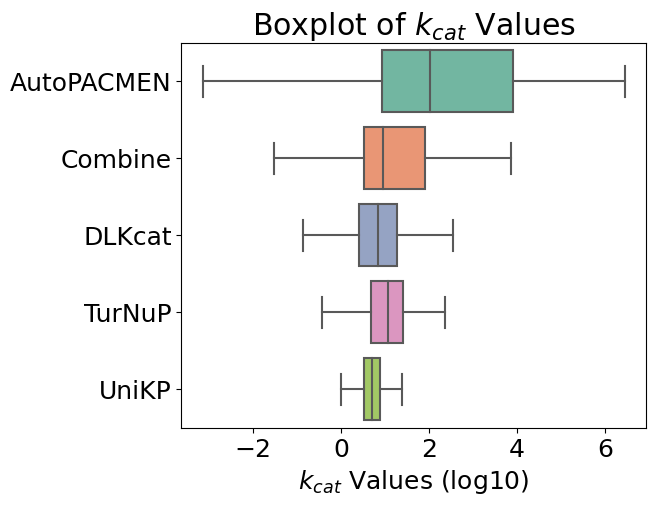

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'

autopacmen_kcat = pd.read_csv("./data/kcat/reaction_kcat_MW_AutoPACMEN.csv",index_col=0)
dlkcat_kcat = pd.read_csv("./data/kcat/reaction_kcat_DLKcat.csv",index_col=0)
turnup_kcat = pd.read_csv("./data/kcat/reaction_kcat_TurNup.csv",index_col=0)
unikp_kcat = pd.read_csv("./data/kcat/reaction_kcat_UniKP.csv",index_col=0)
combine_kcat = pd.read_csv("./analysis/kcat_compare/combine_kcat.csv",index_col=0)

autopacmen_kcat_compare = autopacmen_kcat[["kcat"]]
dlkcat_kcat_compare = dlkcat_kcat[["kcat"]]
turnup_kcat_compare = turnup_kcat[["kcat"]]
unikp_kcat_compare = unikp_kcat[["kcat"]]
combine_kcat_compare = combine_kcat[["kcat"]]

kcat_dataframe = {"AutoPACMEN":autopacmen_kcat_compare, "DLKcat":dlkcat_kcat_compare, "TurNuP":turnup_kcat_compare
        , "UniKP":unikp_kcat_compare, "Combine":combine_kcat_compare}

        
for key, value in kcat_dataframe.items():
    value.rename(columns={'kcat': key}, inplace=True)

#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
y_lab_len = len(kcat_dataframe)
sorted_df_data = dict(sorted(kcat_dataframe.items(), key=lambda x: x[1].columns))

kcat_draw_data = pd.concat(sorted_df_data.values(), axis=1)
kcat_draw_data = kcat_draw_data.replace(0, np.nan)

# np.log10()
kcat_draw_data = kcat_draw_data.apply(pd.to_numeric, errors='coerce')
kcat_draw_data = kcat_draw_data.applymap(np.log10)

# boxplot
plt.figure(figsize=(6,y_lab_len))
sns.boxplot(data=kcat_draw_data, orient="h", palette="Set2", showfliers=False)
plt.title("Boxplot of $k$$_{cat}$ Values")
plt.xlabel("$k$$_{cat}$ Values (log10)")
plt.savefig("./analysis/figure/all_source_boxplot_kcat.png", dpi=300, bbox_inches='tight')
plt.show()

# Coverage

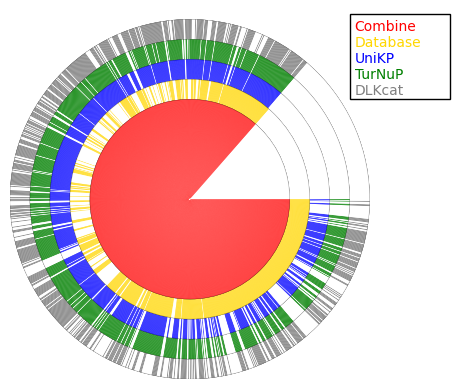

In [3]:
import pandas as pd
import cobra
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

# Load the model
model = cobra.io.load_json_model("./data/iCW773_retgems.json")

# Suppress chained assignment warnings
pd.options.mode.chained_assignment = None

# Load data
data_files = {
    "Database": "./data/kcat/reaction_kcat_MW_AutoPACMEN.csv",
    "DLKcat": "./data/kcat/reaction_kcat_DLKcat.csv",
    "TurNuP": "./data/kcat/reaction_kcat_TurNup.csv",
    "UniKP": "./data/kcat/reaction_kcat_UniKP.csv",
    "Combine": "./analysis/kcat_compare/combine_kcat.csv"
}
kcat_data = {key: pd.read_csv(file, index_col=0) for key, file in data_files.items()}

# Filter out exchange reactions and fill missing kcat values with 0
EX_reaction_list = [reaction.id for reaction in model.reactions if "EX_" in reaction.id]

for name, df in kcat_data.items():
    if name != "Combine":
        for reaction in model.reactions:
            if reaction.id not in df.index and "EX_" not in reaction.id:
                df.loc[reaction.id, "kcat"] = 0
    if 'data_type' in df.columns:
        df['kcat'] = df['kcat'].where(df['data_type'] != 'fill', 0)#Autopacmen remove fill data

# Prepare data for comparison
kcat_compare = {name: df[['kcat']].rename(columns={'kcat': name}) for name, df in kcat_data.items()}
kcat_draw_data = pd.concat(kcat_compare.values(), axis=1).fillna(0)

# Remove spontaneous and exchange reactions
spontaneous_list = kcat_data["Combine"].query("data_type == 'Spontaneous'").index
kcat_draw_data = kcat_draw_data.drop(spontaneous_list.union(EX_reaction_list), errors='ignore')
kcat_draw_data = kcat_draw_data.sort_values(by='Combine', na_position='last')

# Prepare data for pie chart
vals = [1 / len(kcat_draw_data)] * len(kcat_draw_data)
colors_dict = {
    "Combine": 'red', "Database": 'gold', "UniKP": 'blue', "TurNuP": 'green', "DLKcat": 'grey'
}
colors = {name: [colors_dict[name] if val != 0 else 'white' for val in kcat_draw_data[name]] 
          for name in colors_dict.keys()}

fig, ax = plt.subplots()
labels = kcat_draw_data.index.to_list()
circle = plt.Circle((0, 0), 1.8, facecolor='white', edgecolor='black', linewidth=0.3)
ax.add_patch(circle)
ax.pie(vals, radius=1.8, colors=colors['DLKcat'], wedgeprops=dict(alpha = 1))
circle = plt.Circle((0, 0), 1.6, facecolor='white', edgecolor='black', linewidth=0.3)
ax.add_patch(circle)
ax.pie(vals, radius=1.6, colors=colors['TurNuP'], wedgeprops=dict(alpha = 1))
circle = plt.Circle((0, 0), 1.4, facecolor='white', edgecolor='black', linewidth=0.3)
ax.add_patch(circle)
ax.pie(vals, radius=1.4, colors=colors['UniKP'], wedgeprops=dict(alpha = 1))
circle = plt.Circle((0, 0), 1.2, facecolor='white', edgecolor='black', linewidth=0.3)
ax.add_patch(circle)
ax.pie(vals, radius=1.2, colors=colors['Database'], wedgeprops=dict(alpha = 1))
circle = plt.Circle((0, 0), 1, facecolor='white', edgecolor='black', linewidth=0.3)
ax.add_patch(circle)
ax.pie(vals, radius=1, colors=colors['Combine'], wedgeprops=dict(alpha = 1))
ax.set_xlim(-1.8, 2.65)
ax.set_ylim(-1.8, 1.9)
x_start = 1.65
y_start = 1.8
colors = ['red', 'gold', 'blue', 'green', 'grey']
names = ['Combine', 'Database', 'UniKP', 'TurNuP', 'DLKcat']
bbox_props = dict(boxstyle="round,pad=0.5", fc="white", ec="black", lw=0.5)
for name, color in zip(names, colors):
    ax.text(x_start, y_start, name, color=color, ha="left", va="top", size=10)
    y_start -= 0.16
rect = Rectangle((1.60, 1.00), 1.0, 0.85, edgecolor='black', facecolor='none')
ax.add_patch(rect)
plt.savefig('./analysis/figure/kcat_compare.png', dpi=300)
plt.show()


In [4]:
print(len(spontaneous_list))
print(len(EX_reaction_list))

354
181


# Statics

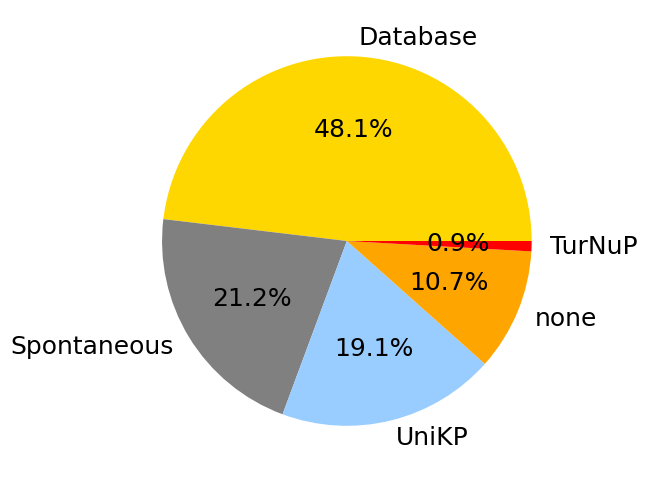

In [5]:
import pandas as pd
combine_kcat = pd.read_csv("./analysis/kcat_compare/combine_kcat.csv",index_col=0)

data_type_counts = combine_kcat['data_type'].value_counts()
plt.figure(figsize=(8, 6))
light_blue = '#99ccff'
plt.pie(data_type_counts, labels=data_type_counts.index, autopct='%1.1f%%', colors=['gold', 'grey', light_blue, 'orange', 'red', 'green'])
plt.title('')
plt.savefig('./analysis/figure/kcat_statics.png', dpi=300)

plt.show()

# Save reaction kcat MW for ecModel

In [6]:
# using ECMpy2 MW
import json
mw_file = "./data/reaction_mw.json"
methods_kcat = {"autopacmen" : autopacmen_kcat, "dlkcat" : dlkcat_kcat, "turnup" : turnup_kcat, "unikp" : unikp_kcat
                , "combine" : combine_kcat}
with open(mw_file, 'r') as f:
    reaction_mw = json.load(f)
for key, method in methods_kcat.items():
    for index,row in methods_kcat[key].iterrows():
        methods_kcat[key].loc[index, "MW"] = 0
        methods_kcat[key].loc[index, "kcat_MW"] = 0
        if index in reaction_mw.keys():
            methods_kcat[key].loc[index, "MW"] = reaction_mw[index]
        if row["kcat"] * methods_kcat[key].loc[index, "MW"] != 0:
            methods_kcat[key].loc[index, "kcat_MW"] = methods_kcat[key].loc[index, "kcat"]*3600000/methods_kcat[key].loc[index, "MW"]
    methods_kcat[key] = methods_kcat[key].replace(0, np.nan)

for key, method in methods_kcat.items():
    methods_kcat[key].fillna(0, inplace=True)
    rows_to_drop = methods_kcat[key][(methods_kcat[key] == 0).any(axis=1)]
    cleaned_df = methods_kcat[key].drop(rows_to_drop.index)
    cleaned_df.to_csv("./analysis/kcat_compare/" + key + "_kcat_mw.csv")